In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import joblib
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# 1. Problem Formulation

Industri film online dipenuhi dengan ribuan film yang dapat dipilih oleh penonton untuk ditonton. Kehadiran sistem rekomendasi telah membantu para penonton untuk memilih film.

Kumpulan data ini berisi informasi mengenai data preferensi pengguna dari 73.516 pengguna terhadap 12.294 anime. Setiap pengguna dapat menambahkan anime ke daftar lengkap mereka dan memberi peringkat. Kumpulan data ini merupakan kompilasi dari peringkat tersebut.

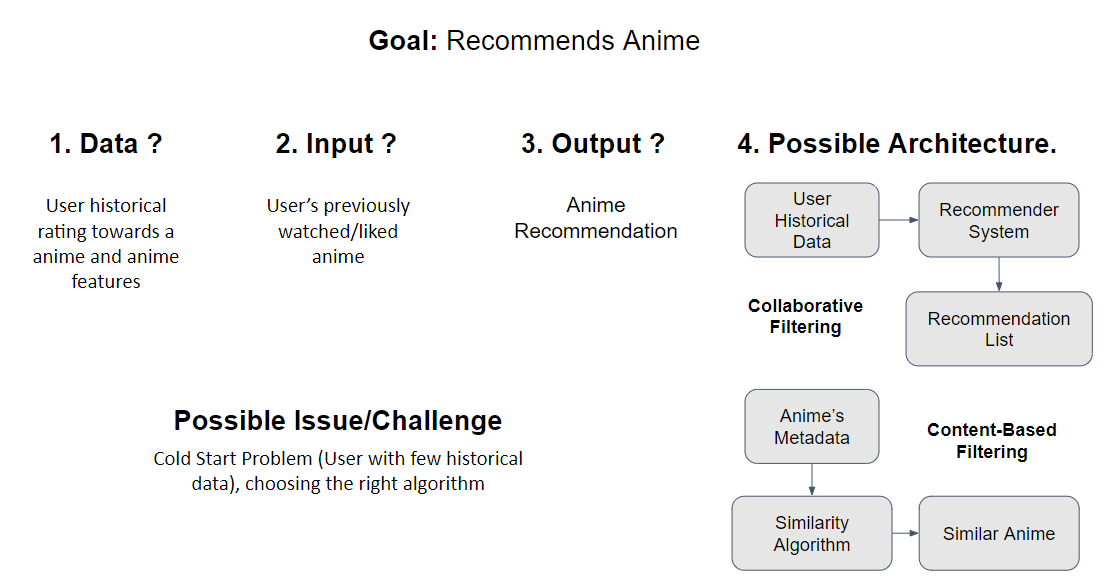

# 2. Data Collection



https://www.kaggle.com/CooperUnion/anime-recommendations-database

In [ ]:
anime_data = pd.read_csv('anime.csv')
rating_data = pd.read_csv('rating.csv')
print(anime_data.shape)
print(rating_data.shape)

(12294, 7)
(7813737, 3)


# 3. Data Preparation

## Quick Look and Preparation

**anime_data**
* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".


**rating_data**
* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it * but didn't assign a rating).

In [ ]:
print(anime_data.shape)
anime_data.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_data.shape

(12294, 7)

In [ ]:
# Fixing anime titles that name uses japanese or special character so the dataframe could read

def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)

    return text

anime_data['name'] = anime_data['name'].apply(text_cleaning)

In [ ]:
print(rating_data.shape)
rating_data.head()

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Menggabungkan data rating dan data anime.


In [ ]:
anime_fulldata = pd.merge(
    anime_data,
    rating_data,
    how='right',
    on='anime_id',
    suffixes=['', '_user']
)

anime_fulldata = anime_fulldata.rename(
    columns={'name': 'anime_title', 'rating_user': 'user_rating'}
)

print(anime_fulldata.shape)
anime_fulldata.head()

(7813737, 9)


,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,1,-1
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,1,-1
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0,1,-1
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0,1,-1
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0,1,-1


# 4. EDA

In [ ]:
print(f"There are {len(rating_data['user_id'].unique()):,} unique users")
print(f"There are {len(rating_data['anime_id'].unique()):,} unique animes")
print(f"There are {len(anime_data['type'].unique()):,} unique type of animes")

There are 73,515 unique users
There are 11,200 unique animes
There are 7 unique type of animes


## Top Rated Animes

Top 15 anime dengan rating tertinggi, yang paling populer.

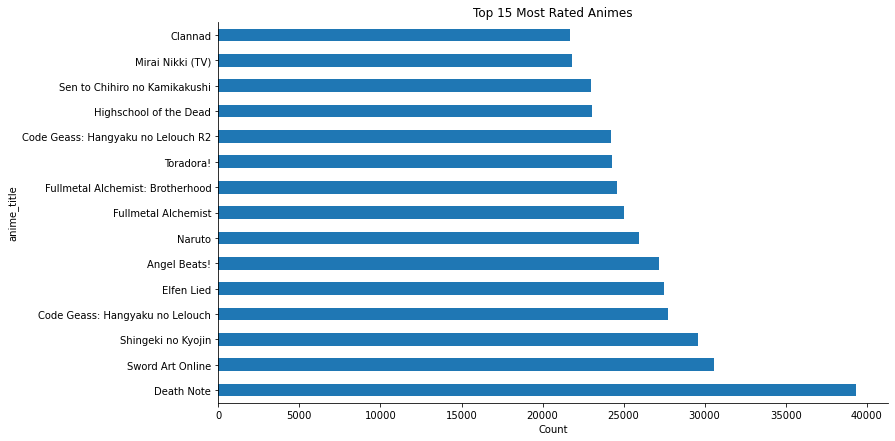

In [ ]:
dfct = anime_fulldata.groupby('anime_title').size().sort_values(ascending=False)

dfct.head(15).plot.barh()
plt.title('Top 15 Most Rated Animes')
plt.xlabel('Count')
plt.show()

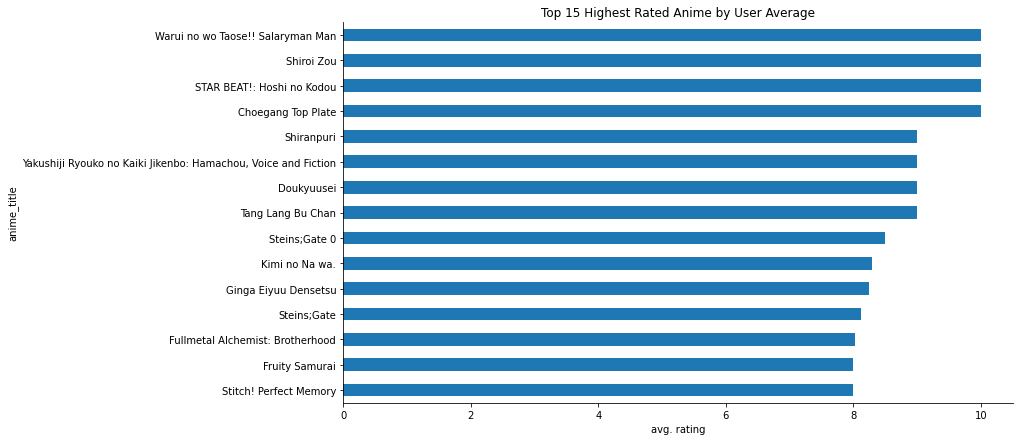

In [ ]:
dfm = anime_fulldata.groupby('anime_title').user_rating.mean().sort_values()

dfm.tail(15).plot.barh()
plt.title('Top 15 Highest Rated Anime by User Average')
plt.xlabel('avg. rating')
plt.show()

Diperhatikan bahwa ada empat anime dengan rating **rata-rata** 10. Apakah mereka benar-benar bagus? Ternyata, anime-anime ini hanya diberi rating satu kali. Tabel berikut memvalidasi kecurigaan kita.

In [ ]:
anime_fulldata.groupby('anime_title').user_rating.agg(['mean', 'count']).sort_values('mean', ascending=False).head(30)

,mean,count
anime_title,,
STAR BEAT!: Hoshi no Kodou,10.000000,1
Warui no wo Taose!! Salaryman Man,10.000000,1
Choegang Top Plate,10.000000,1
Shiroi Zou,10.000000,1
"Yakushiji Ryouko no Kaiki Jikenbo: Hamachou, Voice and Fiction",9.000000,1
Shiranpuri,9.000000,1
Doukyuusei,9.000000,2
Tang Lang Bu Chan,9.000000,1
Steins;Gate 0,8.500000,4


Menggunakan [metode Bayesian] (https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb#Example:-How-to-order-Reddit-submissions). Idenya adalah untuk mengubah peringkat rata-rata ini menjadi [0, 1] dan menggunakan distribusi Beta untuk menggambarkan probabilitas dari peringkat sebenarnya yang diberikan anime.

Dalam kasus ini, kami mengambil perkiraan normal dari distribusi Beta untuk mendapatkan persentil ke-5 dari rating yang sebenarnya. Mengapa persentil ke-5? Dalam hal ini, kami mencoba untuk lebih konservatif, yaitu jika kami tidak memiliki cukup rating, kami akan berasumsi bahwa anime tersebut mungkin buruk. Namun, ketika kita memiliki data yang cukup, asumsi sebelumnya akan kalah oleh bukti. Karena kita tahu bahwa rating tidak akan terdistribusi secara seragam dari 0 hingga 1, kita akan menggunakan prior yang informatif lemah, yaitu rata-rata harus berada di sekitar 7. Distribusi prior dari peringkat tersebut akan terlihat sebagai berikut.


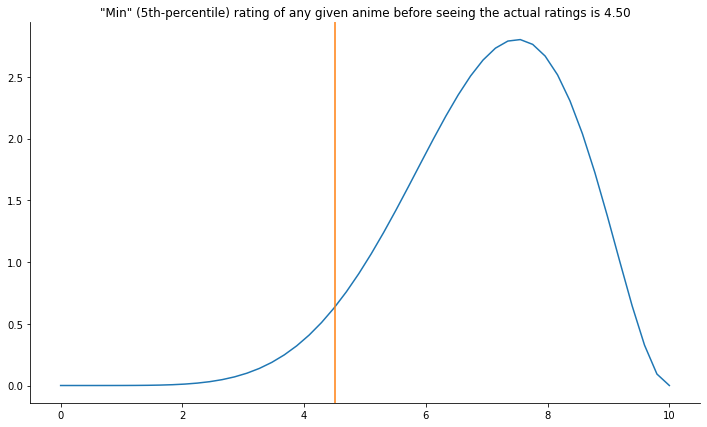

In [ ]:
from scipy.stats import beta

support = np.linspace(0, 1)
plt.plot(support * 10, beta(7, 3).pdf(support))
min_rating = beta(7, 3).ppf(0.05) * 10
plt.axvline(min_rating, color='C1')
plt.title(f'"Min" (5th-percentile) rating of any given anime before seeing the actual ratings is {min_rating:.2f}');

Dengan menggunakan prior ini, kita akan memperbarui posterior kita dengan menjumlahkan peringkat yang dinormalisasi untuk setiap anime dibagi dengan jumlah peringkat. Dengan melakukan ini, kita akan mendapatkan hasil sebagai berikut.

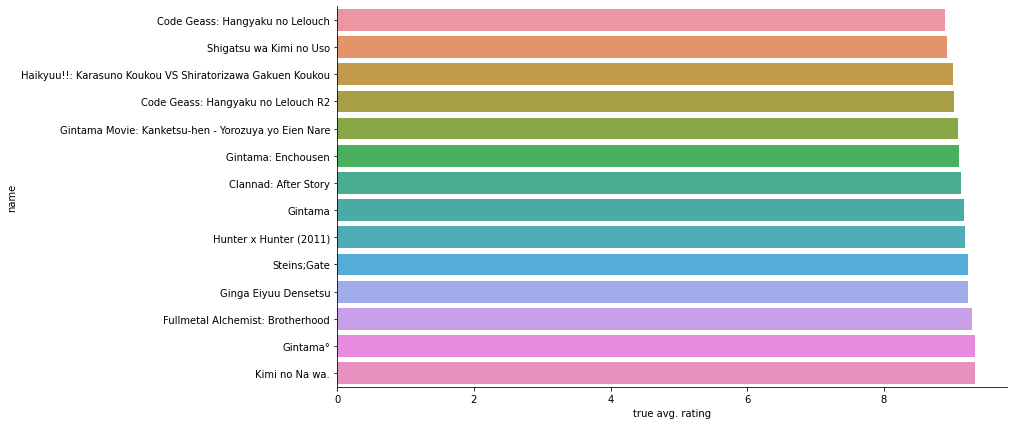

In [ ]:
from scipy.stats import beta

avg_rating = (
    rating_data
    .query('rating != -1')
    .groupby('anime_id')
    .rating
    .agg(['sum', 'count', 'mean'])
)
avg_rating['sum'] /= 10
rating_stats = beta(1 + avg_rating['sum'], 1 + avg_rating['count'] - avg_rating['sum'])
avg_rating['true_avg'] = rating_stats.ppf(.05) * 10

sns.barplot(
    x='true_avg',
    y='name',
    data=pd.merge(
        avg_rating.reset_index(),
        anime_data,
        how='left',
        on='anime_id'
    ).sort_values('true_avg').tail(15),
    ci=False
)
plt.xlabel('true avg. rating');

In [ ]:
pd.merge(
    avg_rating.sort_values('true_avg', ascending=False).head(30),
    anime_data,
    how='left',
    left_index=True,
    right_on='anime_id'
)

,sum,count,mean,true_avg,anime_id,name,genre,type,episodes,rating,members
0,1848.5,1961,9.426313,9.332686,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
2,1122.6,1188,9.449495,9.328532,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
1,20038.3,21494,9.322741,9.293915,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
7,754.0,803,9.389788,9.233121,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
3,15884.1,17151,9.261326,9.227691,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,2888.4,3115,9.272552,9.191645,9969,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
6,6904.7,7477,9.234586,9.182220,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
12,3938.4,4264,9.236398,9.166348,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376
10,14222.7,15518,9.165292,9.127924,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
9,1956.4,2126,9.202258,9.099309,15417,Gintama: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


Melihat gambar dan tabel tersebut, saya rasa kita bisa setuju bahwa anime ini lebih terkenal.

Gambar berikut ini menunjukkan perbedaan antara peringkat situs web dan peringkat pengguna. Perhatikan bahwa distribusi peringkat pengguna memiliki banyak -1 yang berarti "ditonton tetapi tidak diberi peringkat". Selain itu, karena peringkat situs web menunjukkan rata-rata, ia cenderung lebih menyerupai distribusi normal daripada peringkat pengguna.

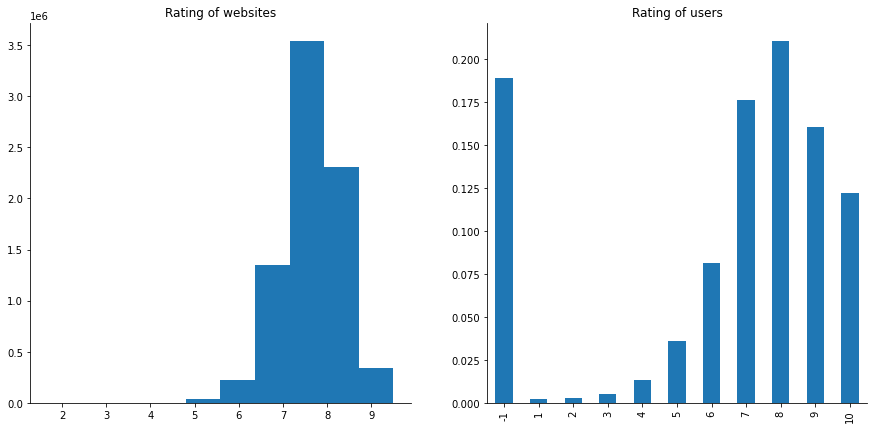

In [ ]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
plt.hist(anime_fulldata['rating'], bins=10)
plt.title("Rating of websites")
plt.subplot(1,2,2)
anime_fulldata['user_rating'].value_counts(True).sort_index().plot.bar()
plt.title("Rating of users")

plt.show()

## Genre

In [ ]:
genre = anime_fulldata['genre'].sample(1_000_000).str.get_dummies(sep=', ')

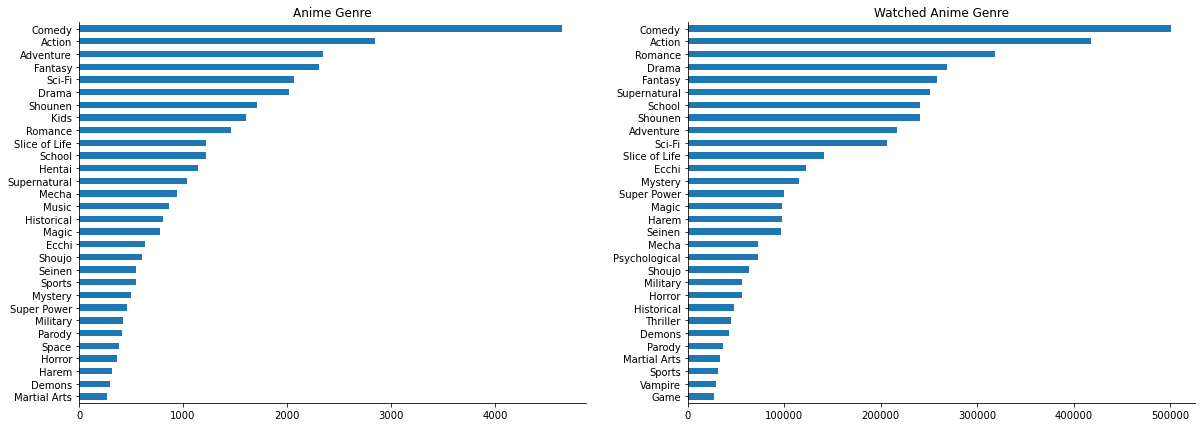

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.subplot(121)
anime_data['genre'].str.get_dummies(sep=', ').sum(axis=0).sort_values().tail(30).plot.barh()
plt.title('Anime Genre')
plt.subplot(122)
genre.sum(axis=0).sort_values().tail(30).plot.barh()
plt.title('Watched Anime Genre');

Karena sebuah anime dapat memiliki lebih dari satu genre, kita dapat melihat distribusinya. Dari gambar berikut, kita dapat melihat bahwa beberapa anime ini tidak memiliki genre yang ditetapkan sementara sebagian besar memiliki 1 sampai 3 genre.

In [ ]:
anime_data['nb_genres'] = anime_data['genre'].str.get_dummies(sep=', ').sum(axis=1)

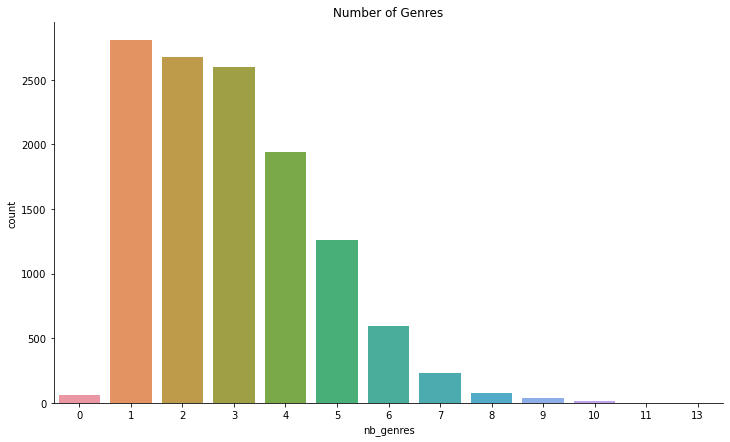

In [ ]:
sns.countplot(x=anime_data['nb_genres'])
plt.title('Number of Genres');

In [ ]:
anime_data.query('nb_genres > 9')

,anime_id,name,genre,type,episodes,rating,members,nb_genres
151,33,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,25,8.40,226430,10
1388,28149,Nihon Animator Mihonichi,"Action, Dementia, Ecchi, Fantasy, Mecha, Milit...",ONA,35,7.56,16942,11
1762,573,Saber Marionette J,"Action, Adventure, Comedy, Drama, Harem, Marti...",TV,25,7.45,17561,10
1845,25157,Trinity Seven,"Action, Comedy, Ecchi, Fantasy, Harem, Magic, ...",TV,12,7.43,208796,10
2554,1397,Macross 7,"Action, Adventure, Comedy, Drama, Mecha, Milit...",TV,49,7.23,15420,10
2903,998,Blue Seed,"Action, Adventure, Comedy, Demons, Drama, Ecch...",TV,26,7.13,15194,10
2992,157,Mahou Sensei Negima!,"Comedy, Ecchi, Fantasy, Harem, Magic, Romance,...",TV,26,7.11,76253,10
3283,6489,Zero no Tsukaima: Princesses no Rondo Picture ...,"Action, Adventure, Comedy, Drama, Ecchi, Fanta...",Special,7,7.04,23532,10
3316,2832,Ani*Kuri15,"Adventure, Comedy, Drama, Fantasy, Game, Magic...",Special,15,7.02,12926,13
4052,32379,Berserk (2016),"Action, Adventure, Demons, Drama, Fantasy, Hor...",TV,12,6.81,90817,10


## Anime Type

Variabel kategorikal lain yang kami miliki dalam data adalah jenis anime. Contohnya adalah [OVA] (https://en.wikipedia.org/wiki/Original_video_animation) dan [ONA] (https://en.wikipedia.org/wiki/Original_net_animation).

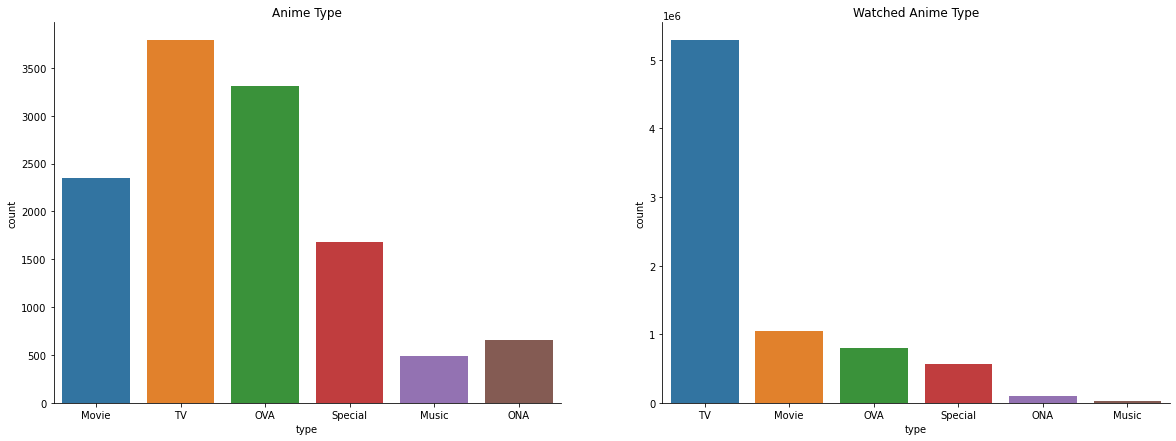

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.subplot(121)
sns.countplot(x='type', data=anime_data)
plt.title('Anime Type')
plt.subplot(122)
sns.countplot(x='type', data=anime_fulldata)
plt.title('Watched Anime Type');

In [ ]:
anime_data['episodes'] = anime_data['episodes'].replace('Unknown', np.nan).astype('float')

## Number of Episodes

Plot berikut ini menunjukkan hubungan antara jumlah episode dan peringkat rata-rata.


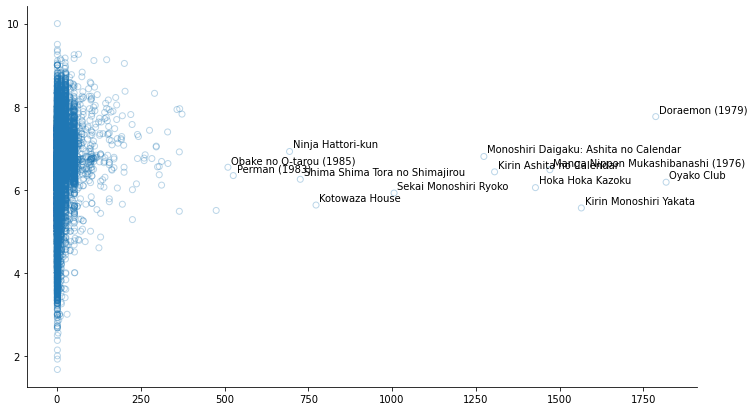

In [ ]:
plt.scatter(
    x='episodes',
    y='rating',
    data=anime_data,
    alpha=.3,
    edgecolor='C0',
    facecolor='none'
)
for idx, row in anime_data.query('episodes > 500').iterrows():
    plt.annotate(row['name'], (row['episodes'] + 10, row['rating'] + 0.1))

# 5. Feature Selection and Engineering

## Menghapus Anime dan Pelanggan dengan Rating Rendah
Kami akan mencoba mengurangi volume data dengan:
* Menghapus anime dengan hanya sedikit peringkat (mereka relatif tidak populer)
* Menghapus pengguna yang hanya memberi peringkat pada beberapa anime (mereka relatif kurang aktif)

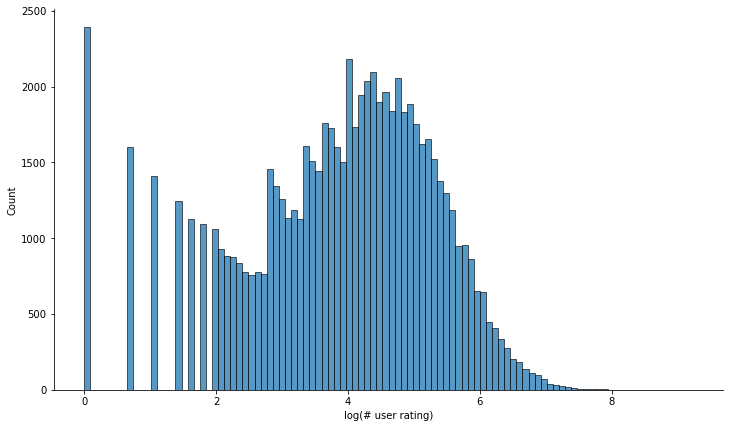

In [ ]:
sns.histplot(x=rating_data.groupby('user_id').size().apply(np.log), bins=100)
plt.xlabel('log(# user rating)');

In [ ]:
rating_data.groupby('user_id').size().describe()

count    73515.000000
mean       106.287656
std        153.086558
min          1.000000
25%         18.000000
50%         57.000000
75%        136.000000
max      10227.000000
dtype: float64

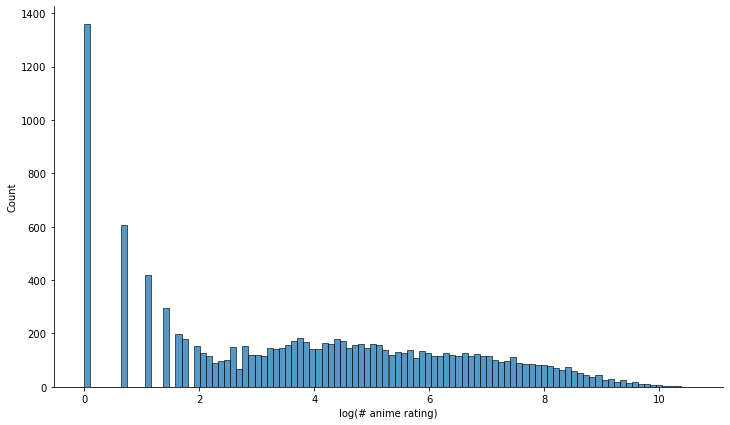

In [ ]:
sns.histplot(x=rating_data.groupby('anime_id').size().apply(np.log), bins=100)
plt.xlabel('log(# anime rating)');

In [ ]:
rating_data.groupby('anime_id').size().describe()

count    11200.000000
mean       697.655089
std       2028.627749
min          1.000000
25%          5.000000
50%         51.500000
75%        385.250000
max      39340.000000
dtype: float64

Kami akan membagi peringkat ke dalam set pelatihan dan pengujian untuk mengevaluasi model kami nanti. Perhatikan bahwa biasanya urutan peringkat ini penting, yaitu

Karena kapasitas mesin yang akan kita gunakan dan masalah cold-start saat melakukan penyaringan kolaboratif, kita hanya akan menggunakan 50% pengguna/anime teratas berdasarkan jumlah peringkat.

In [ ]:
users = rating_data.groupby('user_id').size()
users = users[users.ge(57)].index

animes = rating_data.groupby('anime_id').size()
animes = animes[animes.ge(51)].index

In [ ]:
rating_data.user_id.max(), rating_data.anime_id.max()

(73516, 34519)

In [ ]:
train, test = train_test_split(
    (
        rating_data[~rating_data[['user_id', 'anime_id']].duplicated()]
        .query('rating != -1') # only use explicit feedback
        .query('user_id in @users')
        .query('anime_id in @animes')
        .assign(
            user_code=lambda x: x.user_id.astype('category').cat.codes,
            anime_code=lambda x: x.anime_id.astype('category').cat.codes
        )
    ),
    test_size=0.3,
    random_state=42
)

In [ ]:
print(f"All data      = {len(rating_data):,}")
print(f"Training data = {len(train):,}")
print(f"Test data     = {len(test):,}")

All data      = 7,813,737
Training data = 3,945,558
Test data     = 1,690,954


Dalam beberapa kasus, karena pemisahan secara acak, beberapa pengguna/anime tidak ditemukan dalam training set. Jadi, meskipun kami telah memilih 50% pengguna/anime teratas, kami masih akan melihat masalah cold-start. Untuk mempermudah, kami akan mengecualikan pengguna/anime ini untuk saat ini.

In [ ]:
print(f"Users to remove from the test set: {len(set(test.user_id) - set(train.user_id))}")
print(f"Animes to remove from the test set: {len(set(test.anime_id) - set(train.anime_id))}")

Users to remove from the test set: 140
Animes to remove from the test set: 0


In [ ]:
mask_user = ~test.user_id.isin(set(test.user_id) - set(train.user_id))
mask_anime = ~test.anime_id.isin(set(test.anime_id) - set(train.anime_id))
test = test[mask_user & mask_anime]

In [ ]:
print(f"Training data: {len(train):,}")
print(f"Test data    : {len(test):,}")

Training data: 3,945,558
Test data    : 1,690,787


In [ ]:
anime_map = train[['anime_id', 'anime_code']].drop_duplicates().set_index('anime_id').anime_code.to_dict()
anime_data['anime_code'] = anime_data['anime_id'].map(anime_map).fillna(-1).astype(int)

# 6. ML Training

## Collaborative Filtering

Collaborative filtering is based on the past interactions recorded between users and items in order to produce new recommendations. These interactions are stored in the so-called “user-item interactions matrix" or "utility matrix".

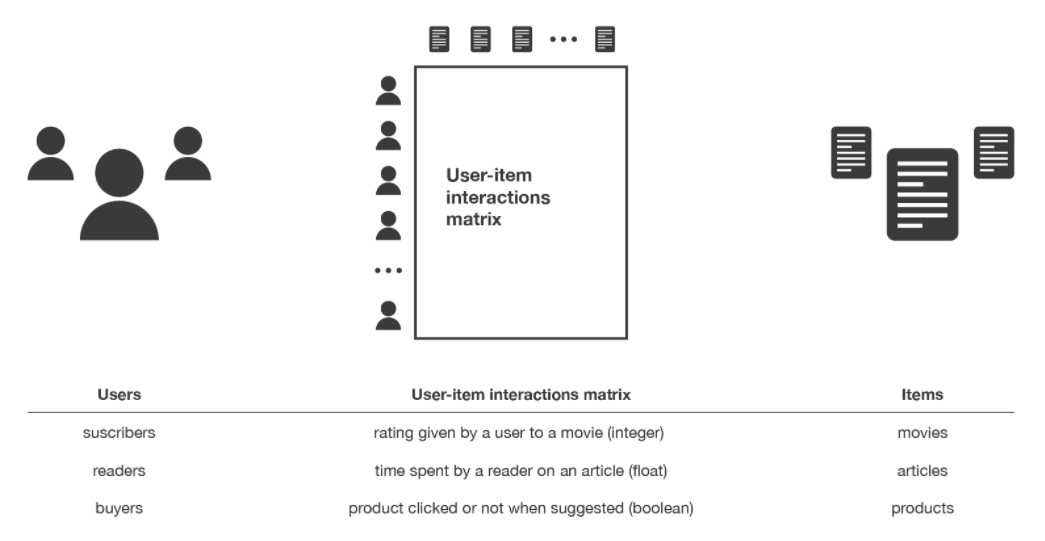

Source: https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada

In [ ]:
train.sample(20, random_state=42).pivot_table(
    index='user_code',
    columns='anime_code',
    values='rating'
).fillna('')

anime_code,197,912,1455,1799,1953,3121,3205,3293,3448,3646,3660,3945,4340,4577,4660,4685,4697,4868,5050,5257
user_code,,,,,,,,,,,,,,,,,,,,
1148,8.0,,,,,,,,,,,,,,,,,,,
1984,,,,,,,,,,,,,,,,,,1.0,,
2065,,,,,,,,,,,,9.0,,,,,,,,
4743,,,,,6.0,,,,,,,,,,,,,,,
8818,,,,,,,,,,,,,,,8.0,,,,,
10932,,,,,,,6.0,,,,,,,,,,,,,
13313,,,,,,6.0,,,,,,,,,,,,,,
13723,,,,,,,,5.0,,,,,,,,,,,,
14711,,,7.0,,,,,,,,,,,,,,,,,


### Baseline

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = train.groupby('anime_code').rating.mean()
pred = pd.merge(
    test, pred,
    how='left',
    left_on='anime_code',
    right_index=True,
    suffixes=('', '_pred')
)
print("By avg. rating per anime")
print(f"MAE = {mean_absolute_error(pred.rating, pred.rating_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(pred.rating, pred.rating_pred)):.2f}")

By avg. rating per anime
MAE = 1.11
RMSE = 1.43


In [ ]:
pred = train.groupby('anime_code').rating.median()
pred = pd.merge(
    test, pred,
    how='left',
    left_on='anime_code',
    right_index=True,
    suffixes=('', '_pred')
)
print("By median rating per anime")
print(f"MAE = {mean_absolute_error(pred.rating, pred.rating_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(pred.rating, pred.rating_pred)):.2f}")

By median rating per anime
MAE = 1.08
RMSE = 1.46


In [ ]:
pred = train.groupby('user_code').rating.mean()
pred = pd.merge(
    test, pred,
    how='left',
    left_on='user_code',
    right_index=True,
    suffixes=('', '_pred')
)
print("By avg. rating per user")
print(f"MAE = {mean_absolute_error(pred.rating, pred.rating_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(pred.rating, pred.rating_pred)):.2f}")

By avg. rating per user
MAE = 1.04
RMSE = 1.36


In [ ]:
pred = train.groupby('user_code').rating.median()
pred = pd.merge(
    test, pred,
    how='left',
    left_on='user_code',
    right_index=True,
    suffixes=('', '_pred')
)
print("By median rating per user")
print(f"MAE = {mean_absolute_error(pred.rating, pred.rating_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(pred.rating, pred.rating_pred)):.2f}")

By median rating per user
MAE = 1.01
RMSE = 1.41


peringkat ini adalah dari 1 hingga 10. Jadi, masuk akal untuk mendapatkan kesalahan sekitar 1 untuk MAE.

### Cosine Similarity

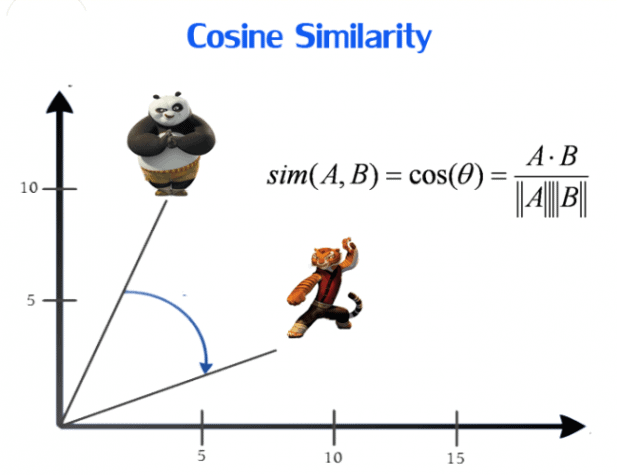

In [ ]:
from scipy.sparse import csr_matrix

X_train = csr_matrix((train.rating, (train.anime_code, train.user_code)))
X_test = csr_matrix((test.rating, (test.anime_code, test.user_code)))

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(X_train_std)
sim, index = knn.kneighbors(X_test_std)

In [ ]:
anime_data[anime_data.anime_code.eq(710)]

,anime_id,name,genre,type,episodes,rating,members,anime_code
206,813,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,291,8.32,375662,710


In [ ]:
anime_data[anime_data.anime_code.isin(index[710])]

,anime_id,name,genre,type,episodes,rating,members,anime_code
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,1316
346,223,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,153,8.16,316102,197
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,10
949,986,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Special,1,7.75,46276,861
1226,901,"Dragon Ball Z Movie 08: Moetsukiro!! Nessen, R...","Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.62,65953,789
2514,898,Dragon Ball Z Movie 05: Tobikkiri no Saikyou t...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.24,59207,786
3053,899,Dragon Ball Z Movie 06: Gekitotsu!! 100-oku Po...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.09,55789,787
3612,894,Dragon Ball Z Movie 01: Ora no Gohan wo Kaese!!,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,6.93,57623,782
3939,897,Dragon Ball Z Movie 04: Super Saiyajin da Son ...,"Adventure, Fantasy, Sci-Fi, Shounen",Movie,1,6.84,51924,785
4444,225,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,64,6.72,226625,198


In [ ]:
X_pred = np.zeros(X_train.shape)
for i, (idx, similarity) in enumerate(zip(index, sim)):
    X_pred[i,:] = similarity * X_train[idx] / np.sum(similarity)

In [ ]:
y = np.array(X_test[X_test.nonzero()]).flatten()
y_pred = np.array(X_pred[X_test.nonzero()]).flatten()
print("Weighted Sum on Similarity Scores")
print(f"MAE = {mean_absolute_error(y, y_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y, y_pred)):.2f}")

Weighted Sum on Similarity Scores
MAE = 4.94
RMSE = 5.34


### Matrix Factorization

In [ ]:
import tensorflow as tf

nb_user = train['user_code'].max() + 1
nb_anime = train['anime_code'].max() + 1

class UVDecomposition(tf.keras.Model):
    def __init__(self, n_dim):
        super(UVDecomposition, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(nb_user, n_dim)
        self.anime_embedding = tf.keras.layers.Embedding(nb_anime, n_dim)

    def call(self, x):
        # Using the functional API
        u = self.user_embedding(tf.cast(x[:,0], dtype='int32'))
        v = self.anime_embedding(tf.cast(x[:,1], dtype='int32'))
        return tf.reduce_sum(u * v, axis=1)

In [ ]:
np.random.seed(42)

model = UVDecomposition(100)
retrain_model = True

if retrain_model:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mean_absolute_error']
    )

    history = model.fit(
        x=train[['user_code', 'anime_code']].values,
        y=train['rating'].values,
        epochs=10,
        batch_size=2**12
    )

    model.save_weights('uv-decomposition')
else:
    model.load_weights('uv-decomposition')

Epoch 1/10
964/964 [==============================] - 20s 20ms/step - loss: 60.0203 - mean_absolute_error: 7.5813
Epoch 2/10
964/964 [==============================] - 19s 20ms/step - loss: 18.6055 - mean_absolute_error: 3.6762
Epoch 3/10
964/964 [==============================] - 19s 20ms/step - loss: 3.5645 - mean_absolute_error: 1.4228
Epoch 4/10
964/964 [==============================] - 19s 20ms/step - loss: 2.0504 - mean_absolute_error: 1.0655 0s - loss: 2.0509 - mean_absolute_error: 1.06
Epoch 5/10
964/964 [==============================] - 19s 20ms/step - loss: 1.6834 - mean_absolute_error: 0.9720
Epoch 6/10
964/964 [==============================] - 19s 20ms/step - loss: 1.5515 - mean_absolute_error: 0.9386
Epoch 7/10
964/964 [==============================] - 19s 20ms/step - loss: 1.4901 - mean_absolute_error: 0.9226
Epoch 8/10
964/964 [==============================] - 19s 20ms/step - loss: 1.4559 - mean_absolute_error: 0.9132
Epoch 9/10
964/964 [============================

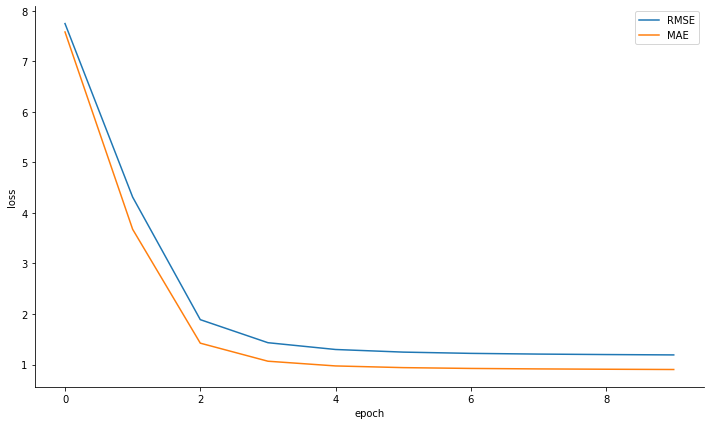

In [ ]:
plt.plot(np.sqrt(history.history['loss']))
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['RMSE', 'MAE']);

In [ ]:
y = test.rating.values
y_pred = model.predict(test[['user_code', 'anime_code']].values)
print("Matrix Factorization")
print(f"MAE = {mean_absolute_error(y, y_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y, y_pred)):.2f}")

Matrix Factorization
MAE = 0.91
RMSE = 1.20


## Content-Based Method

In [ ]:
train_data = pd.merge(
    train,
    anime_data.drop('anime_code', axis=1),
    how='left',
    on='anime_id',
    suffixes=('', '_avg')
)

test_data = pd.merge(
    test,
    anime_data.drop('anime_code', axis=1),
    how='left',
    on='anime_id',
    suffixes=('', '_avg')
)

In [ ]:
train_data.head()

,user_id,anime_id,rating,user_code,anime_code,name,genre,type,episodes,rating_avg,members
0,18798,11977,10,8857,4002,Mahou Shoujo Madoka★Magica Movie 1: Hajimari n...,"Drama, Magic, Psychological, Thriller",Movie,1,8.31,88164
1,66365,245,9,31824,217,Great Teacher Onizuka,"Comedy, Drama, School, Shounen, Slice of Life",TV,43,8.77,268487
2,18717,17247,6,8810,4497,Machine-Doll wa Kizutsukanai,"Action, Ecchi, Fantasy, School, Seinen",TV,12,7.39,136751
3,16865,101,8,7906,78,Air,"Drama, Romance, Slice of Life, Supernatural",TV,13,7.48,188861
4,34851,6,7,16823,2,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

transformers = make_column_transformer(
    (CountVectorizer(tokenizer=lambda x: x.split(', ')), 'genre'),
    (OneHotEncoder(handle_unknown='ignore'), ['type']),
    (StandardScaler(), ['members']),
)

In [ ]:
model = make_pipeline(
    transformers,
    LinearRegression()
)
model.fit(train_data.drop('rating', axis=1), train_data['rating'])
y_pred = model.predict(test_data.drop('rating', axis=1))
print("Linear Regression")
print(f"MAE = {mean_absolute_error(test_data.rating, y_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(test_data.rating, y_pred)):.2f}")

Linear Regression
MAE = 1.17
RMSE = 1.50


In [ ]:
%pip install catboost

In [ ]:
from catboost import CatBoostRegressor

model = make_pipeline(
    transformers,
    CatBoostRegressor(verbose=0, random_state=42)
)
model.fit(train_data.drop('rating', axis=1), train_data['rating'])
y_pred = model.predict(test_data.drop('rating', axis=1))
print("CatBoost")
print(f"MAE = {mean_absolute_error(test_data.rating, y_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(test_data.rating, y_pred)):.2f}")

CatBoost
MAE = 1.11
RMSE = 1.44


In [ ]:
len_features = (
    len(transformers.transformers_[0][1].get_feature_names())
    + len(transformers.transformers_[1][1].get_feature_names())
    + len(transformers.transformers_[-2][-1])
)

## Hybrid-Based Recommender

![Deep Learning](hybrid.png)

In [ ]:
nb_user = train.user_code.max() + 1
nb_anime = train.anime_code.max() + 1

In [ ]:
import tensorflow as tf

class RecNet(tf.keras.Model):
    def __init__(self, n_dim):
        super(RecNet, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(nb_user, n_dim)
        self.anime_embedding = tf.keras.layers.Embedding(nb_anime, n_dim)
        self.concat = tf.keras.layers.Concatenate(axis=1)
        self.linear1 = tf.keras.layers.Dense(128, activation='relu')
        self.linear2 = tf.keras.layers.Dense(32, activation='relu')
        self.final = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        # Using the functional API
        user_embedding = self.user_embedding(tf.cast(x[:,0], dtype='int32'))
        anime_embedding = self.anime_embedding(tf.cast(x[:,1], dtype='int32'))
        x = self.concat([user_embedding, anime_embedding, x[:,2:]])
        x = self.linear1(x)
        x = self.linear2(x)
        return self.final(x)

In [ ]:
transformers = make_column_transformer(
    ('passthrough', ['user_code', 'anime_code']),
    (CountVectorizer(tokenizer=lambda x: x.split(', ')), 'genre'),
    (OneHotEncoder(handle_unknown='ignore'), ['type']),
    (StandardScaler(), ['members']),
)

In [ ]:
np.random.seed(42)

recnet = RecNet(100)
retrain_model = True

if retrain_model:
    recnet.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    history = recnet.fit(
        x=transformers.fit_transform(train_data).toarray(),
        y=train_data['rating'] / 10, # squeeze from [0, 10] -> [0, 1]
        epochs=10,
        batch_size=2**15
    )
    recnet.save_weights('recnet')
else:
    recnet.load_weights('recnet')

Epoch 1/10
121/121 [==============================] - 7s 56ms/step - loss: 0.5295 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0245
Epoch 2/10
121/121 [==============================] - 7s 54ms/step - loss: 0.5021 - mean_absolute_error: 0.0916 - mean_squared_error: 0.0145
Epoch 3/10
121/121 [==============================] - 7s 57ms/step - loss: 0.5005 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0141
Epoch 4/10
121/121 [==============================] - 7s 59ms/step - loss: 0.5001 - mean_absolute_error: 0.0894 - mean_squared_error: 0.0139
Epoch 5/10
121/121 [==============================] - 7s 55ms/step - loss: 0.4997 - mean_absolute_error: 0.0890 - mean_squared_error: 0.0138
Epoch 6/10
121/121 [==============================] - 7s 56ms/step - loss: 0.4992 - mean_absolute_error: 0.0884 - mean_squared_error: 0.0136
Epoch 7/10
121/121 [==============================] - 7s 55ms/step - loss: 0.4986 - mean_absolute_error: 0.0878 - mean_squared_error: 0.0134
Epoch 8/10
12

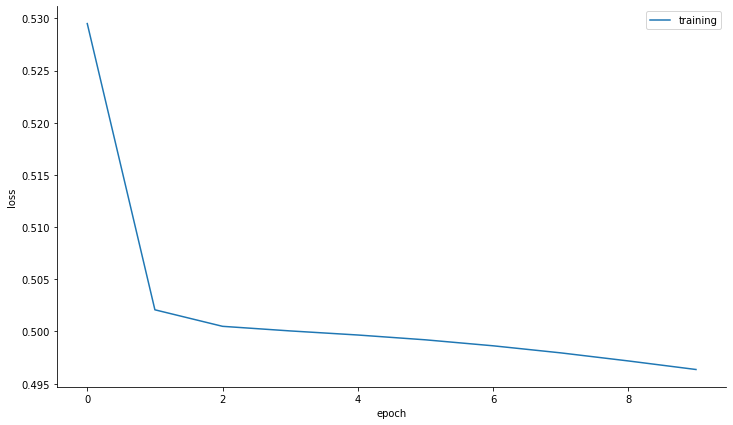

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training']);

In [ ]:
y_pred = recnet.predict(transformers.transform(test_data).toarray())
y_pred = y_pred.flatten() * 10

In [ ]:
print("Deep Learning")
print(f"MAE = {mean_absolute_error(test_data.rating, y_pred):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(test_data.rating, y_pred)):.2f}")

Deep Learning
MAE = 0.87
RMSE = 1.15
